FOPDT based on the model for vehicle velocity.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Imports and helpers

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

## Mathematical model

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p u(t) - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta)$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

def vehicle_model(v, t, u_func, theta_func):
    
    u = u_func(t)
    theta = theta_func(t)
        
    drive = F_p * u
    drag = 0.5 * rho * A * C_d * (v**2)
    slope = constants.g * np.sin(theta)
    
    return (1. / m) * (drive - drag) - slope
    

## Simulation

In [6]:
t = np.linspace(0, 200, 100)

In [7]:
step_t = 25
step_val = 50

# input function
def step_input(t):
    return 0 if t < step_t else step_val

# disturbance function
def no_slope(t):
    return 0

The original model

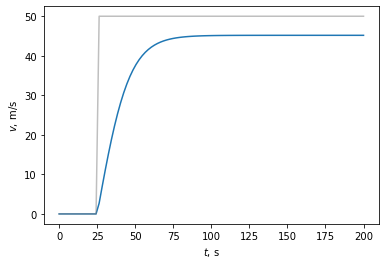

In [8]:
initial = 0

v_sim = odeint(vehicle_model, initial, t, args=(step_input, no_slope))

plt.plot(t, v_sim)
plt.plot(t, eval_model(step_input, t), color='gray', alpha=0.5)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

FOPDT model with manual tuning

$\tau \frac{dy(t)}{dt} = -y(t) + K u(t - \theta) $

In [9]:
def create_fopdt(K, tau, theta, u_func):
    
    def model(y, t):
        
        u = u_func(t - theta)
        
        return (1. / tau) * (-y + K * u)
    
    return model

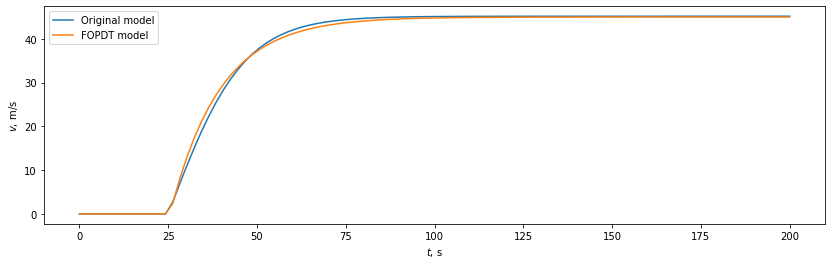

In [10]:
# Gain
gain = 0.9

# Time constant
time_const = 14.

# Deadtime (delay)
delay = 0.5

fopdt_model = create_fopdt(gain, time_const, delay, u_func=step_input)

fopdt_sim = odeint(fopdt_model, 0, t)

plt.figure(figsize=(14, 4))
plt.plot(t, v_sim, label='Original model')
plt.plot(t, fopdt_sim, label='FOPDT model')
plt.legend()
plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

Comparing simulated results of the original model and the FOPDT model

In [11]:
np.hstack((v_sim, fopdt_sim))

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 2.70239734,  2.3857295 ],
       [ 6.97831947,  8.11189868],
       [11.12987415, 13.06863047],
       [15.09049384, 17.35931582],
       [18.80614393, 21.07345273],
       [22.23755514, 24.28851328],
       [25.36072568, 27.07155943],
       [28.16594808, 29.48064177],
       [30.65577747, 31.56601065],
       [32.84243422, 33.37116413],
       [34.74507578, 34.93375533],
       [36.38725492, 36.28637795],
       [37.79476166, 37.45724552],
       [38.99392674, 38.47078119],
       [40.01038655, 39.34812605],
       [40.86825617,

## Tuning correlations

http://apmonitor.com/pdc/index.php/Main/ProportionalControl

In [12]:
def tune_p(gain, time_const, delay):
    return (0.202 / gain) * (delay / time_const) ** (-1.219)

tune_p(gain, time_const, delay)

13.037505366934615

http://apmonitor.com/pdc/index.php/Main/ProportionalIntegralControl

In [13]:
def tune_pi_imc(gain, time_const, delay):
    
    tau_c = max((time_const, 8 * delay))
    
    K_c = (1. / gain) * (time_const / (delay + tau_c))
    
    return K_c, time_const


tune_pi_imc(gain, time_const, delay)

(1.0727969348659006, 14.0)

In [14]:
def tune_pi_itae(gain, time_const, delay):
    
    ratio = (delay / time_const)
    
    K_c = (0.586 / gain ) * ratio ** (-0.916)
    
    tau_i = time_const / (1.03 - 0.165 * ratio)
    
    return K_c, tau_i

tune_pi_itae(gain, time_const, delay)

(13.780083947845885, 13.670444638186574)